# Notebook 2: Obtain & Process Test Data Set

Following the method established in Notebook 1, we want to create a test set of multiple days' data.


## 1. Obtaining Data

As per Notebook 1, obtain the data for multiple days from the AWS PDS S3 bucket.
We output a single dataset:

### Cooked dataset 

Contains top 100 stocks by trade volume for the days from 2018-01-01 to 2018-03-23 excluding days with no
trades.
We have filled in missing trades to have volume 0 and missing prices by forward filling.
We have added an extra column called `HasTrade` to indicate if the values were filled-in.
The data is saved in picked format (pkl) and in csv format. The csv format does not preserve the index.
The picked format preserves the multi-index (by Mnemonic and CalcDataTime). The index values are sorted
by Mnemonic and then by CalcDateTime

```
/data/processed/cooked_v3.csv
/data/processed/cooked_v3.pkl
```

Prefer using `/data/processed/cooked_v3.pkl` since it preserves the indices.

In [28]:
import pandas as pd
import os.path

enable_assert = True 

# Edit the start/end date and the output folders
from_date = '2018-01-01'
until_date = '2018-03-23'

# if you enable assert set from_date and until date as below
if enable_assert:
    from_date = '2018-01-01'
    until_date = '2018-03-23'

local_data_folder = '/data/deutsche-boerse-xetra-pds' # do not end in /
output_folder = '/data/processed' # do not end in /

download_script = '/data/deutsche-boerse-xetra-pds/download.sh'

dates = list(pd.date_range(from_date, until_date, freq='D').strftime('%Y-%m-%d'))

! mkdir -p {local_data_folder}/{date}

# We found it was more reliable to generate a bash script and run it, rather than
# run the commands in a python for-loop

with open(download_script, 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("\nset -euo pipefail\n")
    f.write("\n# This script was generated to download data for multiple days\n")
    for date in dates:
        success_file =  os.path.join(local_data_folder, date, 'success')

        f.write("""
if [ ! -f {success_file} ]; then

    echo "Getting PDS dataset for date {date}"        
    mkdir -p {local_data_folder}/{date}
    aws s3 sync s3://deutsche-boerse-xetra-pds/{date} {local_data_folder}/{date} --no-sign-request
    touch {success_file}            
else
    echo "PDS dataset for date {date} already exists"
fi\n""".format(success_file=success_file, date=date, local_data_folder=local_data_folder))

        
! chmod +x {download_script}     
! head -n 15 {download_script} 

#!/bin/bash

set -euo pipefail

# This script was generated to download data for multiple days

if [ ! -f /data/deutsche-boerse-xetra-pds/2018-01-01/success ]; then

    echo "Getting PDS dataset for date 2018-01-01"        
    mkdir -p /data/deutsche-boerse-xetra-pds/2018-01-01
    aws s3 sync s3://deutsche-boerse-xetra-pds/2018-01-01 /data/deutsche-boerse-xetra-pds/2018-01-01 --no-sign-request
    touch /data/deutsche-boerse-xetra-pds/2018-01-01/success            
else
    echo "PDS dataset for date 2018-01-01 already exists"
fi


In [2]:
!  {download_script}

PDS dataset for date 2018-01-01 already exists
PDS dataset for date 2018-01-02 already exists
PDS dataset for date 2018-01-03 already exists
PDS dataset for date 2018-01-04 already exists
PDS dataset for date 2018-01-05 already exists
PDS dataset for date 2018-01-06 already exists
PDS dataset for date 2018-01-07 already exists
PDS dataset for date 2018-01-08 already exists
PDS dataset for date 2018-01-09 already exists
PDS dataset for date 2018-01-10 already exists
PDS dataset for date 2018-01-11 already exists
PDS dataset for date 2018-01-12 already exists
PDS dataset for date 2018-01-13 already exists
PDS dataset for date 2018-01-14 already exists
PDS dataset for date 2018-01-15 already exists
PDS dataset for date 2018-01-16 already exists
PDS dataset for date 2018-01-17 already exists
PDS dataset for date 2018-01-18 already exists
PDS dataset for date 2018-01-19 already exists
PDS dataset for date 2018-01-20 already exists
PDS dataset for date 2018-01-21 already exists
PDS dataset f

## 2. Data Preprocessing

As per Notebook 2, we need to ensure we have a data frame of 'common stock' in a suitable form. We take care to filter out any data outside of trading hours also to ensure consistency.

In [3]:
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs

In [5]:
def load_csv_dirs(data_dirs):
    files = []
    for data_dir in data_dirs:
        files.extend(glob.glob(os.path.join(data_dir, '*.csv')))
    return pd.concat(map(pd.read_csv, files))

data_dir = local_data_folder + '/'
data_subdirs = map(lambda date: data_dir + date, dates)
unprocessed_df = load_csv_dirs(data_subdirs)
unprocessed_df.head(2)

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-01-02,09:00,18.78,18.78,18.73,18.73,473,3
1,AT0000969985,AUS,AT+S AUSTR.T.+SYSTEMT.,Common stock,EUR,2504191,2018-01-02,09:00,23.55,23.55,23.55,23.55,228,1


In [6]:
unprocessed_df.count()

ISIN              4104419
Mnemonic          4104400
SecurityDesc      4104419
SecurityType      4104419
Currency          4104419
SecurityID        4104419
Date              4104419
Time              4104419
StartPrice        4104419
MaxPrice          4104419
MinPrice          4104419
EndPrice          4104419
TradedVolume      4104419
NumberOfTrades    4104419
dtype: int64

In [7]:
if enable_assert:
    assert(unprocessed_df.shape[0] == 4104419)

In [8]:
# we want the dates to be comparable to datetime.strptime()
unprocessed_df["CalcTime"] = pd.to_datetime("1900-01-01 " + unprocessed_df["Time"])

unprocessed_df["CalcDateTime"] = pd.to_datetime(unprocessed_df["Date"] + " " + unprocessed_df["Time"])
unprocessed_df.head()

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-01-02,09:00,18.78,18.78,18.73,18.73,473,3,1900-01-01 09:00:00,2018-01-02 09:00:00
1,AT0000969985,AUS,AT+S AUSTR.T.+SYSTEMT.,Common stock,EUR,2504191,2018-01-02,09:00,23.55,23.55,23.55,23.55,228,1,1900-01-01 09:00:00,2018-01-02 09:00:00
2,CA32076V1031,FMV,FIRST MAJESTIC SILVER,Common stock,EUR,2504197,2018-01-02,09:00,5.71,5.71,5.71,5.71,31,1,1900-01-01 09:00:00,2018-01-02 09:00:00
3,CH0038863350,NESR,"NESTLE NAM. SF-,10",Common stock,EUR,2504245,2018-01-02,09:00,71.86,71.86,71.84,71.84,504,2,1900-01-01 09:00:00,2018-01-02 09:00:00
4,CH0244767585,0UB,"UBS GROUP AG SF -,10",Common stock,EUR,2504253,2018-01-02,09:00,15.27,15.27,15.27,15.27,500,1,1900-01-01 09:00:00,2018-01-02 09:00:00


In [9]:
test1 = unprocessed_df[(unprocessed_df.Mnemonic == 'BMW') &
                 (unprocessed_df.Date == '2018-01-02') &
                 (unprocessed_df.Time == '09:01')]
test1

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
235,DE0005190003,BMW,BAY.MOTOREN WERKE AG ST,Common stock,EUR,2504900,2018-01-02,09:01,84.34,84.47,84.32,84.47,4143,31,1900-01-01 09:01:00,2018-01-02 09:01:00


In [10]:
test2 = unprocessed_df[(unprocessed_df.Mnemonic == 'BMW') &
                 (unprocessed_df.Date == '2018-01-02') &
                 (unprocessed_df.Time == '09:02')]
test2

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
376,DE0005190003,BMW,BAY.MOTOREN WERKE AG ST,Common stock,EUR,2504900,2018-01-02,09:02,84.48,84.63,84.48,84.63,2760,30,1900-01-01 09:02:00,2018-01-02 09:02:00


In [11]:
if enable_assert:
    assert (test1['EndPrice'].values[0] == 84.47)
    assert (test1['TradedVolume'].values[0] == 4143)

In [12]:
# Filter common stock
# Filter between trading hours 08:00 and 20:00
# Exclude auctions (those are with TradeVolume == 0)
only_common_stock = unprocessed_df[unprocessed_df.SecurityType == 'Common stock']
time_fmt = "%H:%M"
opening_hours_str = "08:00"
closing_hours_str = "20:00"
opening_hours = datetime.strptime(opening_hours_str, time_fmt)
closing_hours = datetime.strptime(closing_hours_str, time_fmt)

cleaned_common_stock = only_common_stock[(only_common_stock.TradedVolume > 0) & \
                  (only_common_stock.CalcTime >= opening_hours) & \
                  (only_common_stock.CalcTime <= closing_hours)]
cleaned_common_stock.head(2)

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-01-02,09:00,18.78,18.78,18.73,18.73,473,3,1900-01-01 09:00:00,2018-01-02 09:00:00
1,AT0000969985,AUS,AT+S AUSTR.T.+SYSTEMT.,Common stock,EUR,2504191,2018-01-02,09:00,23.55,23.55,23.55,23.55,228,1,1900-01-01 09:00:00,2018-01-02 09:00:00


In [13]:
if enable_assert:
    tmp = cleaned_common_stock[(cleaned_common_stock.Mnemonic == 'BMW') &
                 (cleaned_common_stock.Date == '2018-01-02') &
                 (cleaned_common_stock.Time == '09:01')]
    assert (tmp['EndPrice'].values[0] == 84.47)

In [14]:
bymnemonic = cleaned_common_stock[['Mnemonic', 'TradedVolume']].groupby(['Mnemonic']).sum()
number_of_stocks = 100
top = bymnemonic.sort_values(['TradedVolume'], ascending=[0]).head(number_of_stocks)
top.head(10)

,TradedVolume
Mnemonic,
SNH,1528627270
DBK,825208182
EOAN,669796829
DTE,660199152
CBK,461376611
RWE,327118659
IFX,259591428
DAI,165257767
LHA,152361782


In [15]:
top_k_stocks = list(top.index.values)
cleaned_common_stock = cleaned_common_stock[cleaned_common_stock.Mnemonic.isin(top_k_stocks)]
cleaned_common_stock.head()

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-01-02,09:00,18.780,18.780,18.730,18.730,473,3,1900-01-01 09:00:00,2018-01-02 09:00:00
14,DE000A0D6554,NDX1,NORDEX SE O.N.,Common stock,EUR,2504290,2018-01-02,09:00,8.880,8.898,8.876,8.898,1159,5,1900-01-01 09:00:00,2018-01-02 09:00:00
18,DE000A0HN5C6,DWNI,DEUTSCHE WOHNEN SE INH,Common stock,EUR,2504314,2018-01-02,09:00,36.150,36.150,36.080,36.100,1695,12,1900-01-01 09:00:00,2018-01-02 09:00:00
22,DE000A0STST2,TTI,TOM TAILOR HLDG NA O.N.,Common stock,EUR,2504401,2018-01-02,09:00,10.700,10.700,10.700,10.700,500,3,1900-01-01 09:00:00,2018-01-02 09:00:00
23,DE000A0WMPJ6,AIXA,AIXTRON SE NA O.N.,Common stock,EUR,2504428,2018-01-02,09:00,11.465,11.465,11.435,11.440,1262,5,1900-01-01 09:00:00,2018-01-02 09:00:00


In some notebooks we use a subset of this data, and therefore we export it here

In [16]:
sorted_by_index = cleaned_common_stock.set_index(['Mnemonic', 'CalcDateTime']).sort_index()
sorted_by_index.head()

ISIN       SecurityDesc  SecurityType  \
Mnemonic CalcDateTime                                                         
1COV     2018-01-02 08:02:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-01-02 08:03:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-01-02 08:04:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-01-02 08:05:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-01-02 08:06:00  DE0006062144  COVESTRO AG  O.N.  Common stock   

                             Currency SecurityID        Date   Time  \
Mnemonic CalcDateTime                                                 
1COV     2018-01-02 08:02:00      EUR    2505008  2018-01-02  08:02   
         2018-01-02 08:03:00      EUR    2505008  2018-01-02  08:03   
         2018-01-02 08:04:00      EUR    2505008  2018-01-02  08:04   
         2018-01-02 08:05:00      EUR    2505008  2018-01-02  08:05   
         2018-01-02 08:06:00      EUR    2505008  2018-01-02  08:06   

                              StartPrice  MaxPrice  MinPrice  EndPrice  \
Mnemonic CalcDateTime                                                    
1COV     2018-01-02 08:02:00       86.20     86.38     86.20     86.34   
         2018-01-02 08:03:00       86.18     86.18     86.10     86.12   
         2018-01-02 08:04:00       86.00     86.08     86.00     86.08   
         2018-01-02 08:05:00       85.92     86.00     85.86     85.98   
         2018-01-02 08:06:00       85.90     85.90     85.80     85.84   

                             TradedVolume NumberOfTrades            CalcTime  
Mnemonic CalcDateTime                                                         
1COV     2018-01-02 08:02:00          436              6 1900-01-01 08:02:00  
         2018-01-02 08:03:00          568              7 1900-01-01 08:03:00  
         2018-01-02 08:04:00          345              4 1900-01-01 08:04:00  
         2018-01-02 08:05:00         3175             18 1900-01-01 08:05:00  
         2018-01-02 08:06:00         1487              9 1900-01-01 08:06:00

In [17]:
non_empty_days = sorted(list(cleaned_common_stock['Date'].unique()))
len(non_empty_days), non_empty_days[0:2], '...', non_empty_days[-3:-1]

(59, ['2018-01-02', '2018-01-03'], '...', ['2018-03-21', '2018-03-22'])

In [18]:
import datetime
def build_index(non_empty_days, from_time, to_time):
    date_ranges = []
    for date in non_empty_days:
        yyyy, mm, dd = date.split('-')
        from_hour, from_min = from_time.split(':')
        to_hour, to_min = to_time.split(':')    
        t1 = datetime.datetime(int(yyyy), int(mm), int(dd), int(from_hour),int(from_min),0)
        t2 = datetime.datetime(int(yyyy), int(mm), int(dd), int(to_hour),int(to_min),0) 
        date_ranges.append(pd.DataFrame({"OrganizedDateTime": pd.date_range(t1, t2, freq='1Min').values}))
    agg = pd.concat(date_ranges, axis=0) 
    agg.index = agg["OrganizedDateTime"]
    return agg
new_datetime_index = build_index(non_empty_days, opening_hours_str, closing_hours_str)["OrganizedDateTime"].values
new_datetime_index

array(['2018-01-02T08:00:00.000000000', '2018-01-02T08:01:00.000000000',
       '2018-01-02T08:02:00.000000000', ...,
       '2018-03-23T19:58:00.000000000', '2018-03-23T19:59:00.000000000',
       '2018-03-23T20:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
if enable_assert:
    assert(new_datetime_index[0] == np.datetime64('2018-01-02T08:00:00.000000000'))
    assert(new_datetime_index[10] == np.datetime64('2018-01-02T08:10:00.000000000'))
    assert(new_datetime_index[-2] == np.datetime64('2018-03-23T19:59:00.000000000'))    
    assert(new_datetime_index[-1] == np.datetime64('2018-03-23T20:00:00.000000000'))

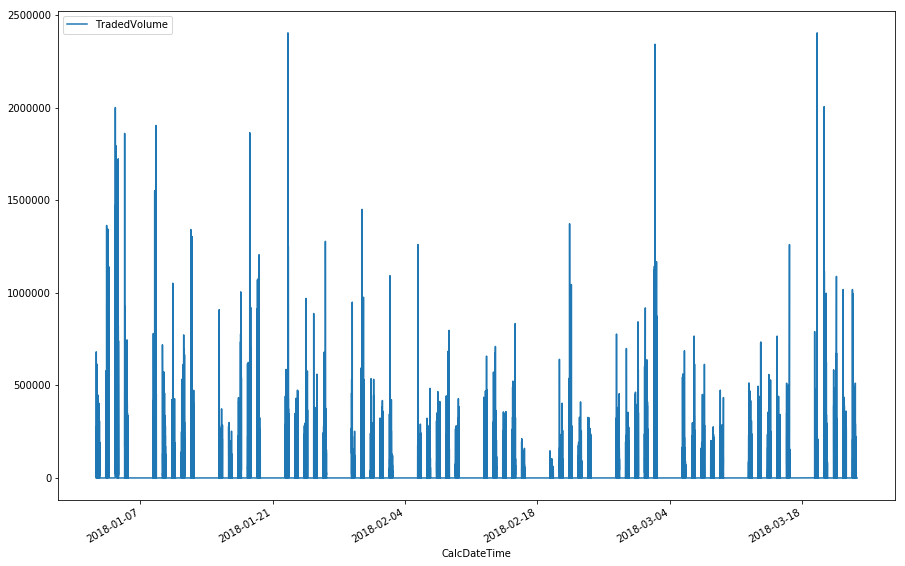

In [20]:
def basic_stock_features(input_df, mnemonic, new_time_index):
    stock = sorted_by_index.loc[mnemonic].copy()

    stock['HasTrade'] = 1.0
    
    stock = stock.reindex(new_time_index)
    
    features = ['MinPrice', 'MaxPrice', 'EndPrice', 'StartPrice']
    for f in features:
        stock[f] = stock[f].fillna(method='ffill')   
    
    features = ['HasTrade', 'TradedVolume', 'NumberOfTrades']
    for f in features:
        stock[f] = stock[f].fillna(0.0)
    
    stock['Mnemonic'] = mnemonic
    selected_features = ['Mnemonic', 'MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice', 'HasTrade', 'TradedVolume', 'NumberOfTrades']
    return stock[selected_features]


snh = basic_stock_features(sorted_by_index, 'SNH', new_datetime_index)
snh[['TradedVolume']].plot()

In [21]:
snh.head()

,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades
CalcDateTime,,,,,,,,
2018-01-02 08:00:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:01:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:02:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:03:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:04:00,SNH,0.38,0.389,0.385,0.389,1.0,172091.0,39.0


In [22]:
if enable_assert:
    tmp = basic_stock_features(sorted_by_index, 'BMW', new_datetime_index)
    tmp = tmp[tmp.index == np.datetime64('2018-01-02T09:01:00.000000000')]
    assert (tmp['EndPrice'].values[0] == 84.47)
    assert (tmp['TradedVolume'].values[0] == 4143)

In [23]:
stocks = []
for stock in top_k_stocks:
    stock = basic_stock_features(sorted_by_index, stock, new_datetime_index)
    stocks.append(stock)
# prepared should contain the numeric features for all top k stocks,
# for all days in the interval, for which there were trades (that means excluding weekends and holidays)
# for all minutes from 08:00 until 20:00
# in minutes without trades the prices from the last available minute are carried forward
# trades are filled with zero for such minutes
# a new column called HasTrade is introduced to denote the presence of trades
prepared = pd.concat(stocks, axis=0)

In [24]:
prepared['Mnemonic'].unique(), prepared['Mnemonic'].unique().shape[0]

(array(['SNH', 'DBK', 'EOAN', 'DTE', 'CBK', 'RWE', 'IFX', 'DAI', 'LHA',
        'AT1', 'O2D', 'SVAB', 'DPW', 'BAYN', 'SAP', 'SIE', 'BAS', 'TKA',
        'AIXA', 'PSM', 'BMW', 'HDD', 'EVT', 'VOW3', 'ALV', 'FRE', 'VNA',
        'IGY', 'CEC', 'USE', 'SDF', 'SHA', 'GAZ', 'NOA3', 'ADS', 'VODI',
        '1COV', 'B4B', 'SHL', 'TUI1', 'SZU', 'DLG', 'NDX1', 'HEN3', 'WDI',
        'HEI', 'BPE5', 'MUV2', 'FNTN', 'DWNI', 'EVK', 'ARO', 'MRK', 'KCO',
        'UN01', 'FME', 'DB1', 'AB1', 'AOX', 'PAH3', 'QIA', 'CON', 'RKET',
        'G1A', 'LINU', 'BVB', 'ZAL', 'RIB', 'PBB', 'TINA', 'BEI', 'MDG1',
        'PNE3', 'OSR', 'DEZ', '3W9K', 'ADV', 'TEG', 'TTI', 'SOW', 'QSC',
        'ARL', 'LXS', 'SGL', 'GYC', 'UTDI', 'WAF', 'SZG', 'NDA', 'DHER',
        'SANT', 'B8F', 'CAP', 'BOSS', 'INN1', 'KGX', 'SY1', 'BNR', 'WCH',
        'DRI'], dtype=object), 100)

In [25]:
prepared.head()

,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades
CalcDateTime,,,,,,,,
2018-01-02 08:00:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:01:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:02:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:03:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-02 08:04:00,SNH,0.38,0.389,0.385,0.389,1.0,172091.0,39.0


In [26]:
if enable_assert:
    tmp = prepared[prepared.Mnemonic == 'BMW']
    tmp = tmp[tmp.index == np.datetime64('2018-01-02T09:01:00.000000000')]
    assert (tmp['EndPrice'].values[0] == 84.47)
    assert (tmp['TradedVolume'].values[0] == 4143)

In [27]:
# We save both in csv in pickle. Generally we'd read from the pickeled format because 
# it preserves the indices, but for cases where pkl cannot be read, we also output a csv format
! mkdir -p {output_folder}
prepared.to_csv(output_folder + '/cooked_v3.csv')

prepared.to_pickle(output_folder + '/cooked_v3.pkl')

## In the future:
    - prepare data by 5 min, 15 min, 30 min, 1 hour, 1 day
    - add extra (derived) features